# Finding Critical Points with TensorFlow
## Part 2 - Critical Points of Neural Networks

This section is under construction.

In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from crit_finder import train, evaluate
from crit_finder.graphs import nn

The tricky part here is specifying the parameters: in order to calculate a Hessian, we need the parameters to be inside the same variable, but TensorFlow is not designed with the expectation that all of our weights need to be initialized at once. In addition, this makes keeping abstraction barriers up more difficult.

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


The biggest practical issue is handling the non-invertibility of the Hessian and related numerical issues in the Newton method. Seems like it requires fairly careful tuning of the step size, or else it can cause the performance to drop and/or the (raw) gradients to blow up.

In [3]:
fudged_hess_hyperparameters = {"layer_sizes":[10],
                            "nonlinearity":tf.nn.relu,
                            "input_size":784,
                            "output_size":10,
                             "learning_rate":0.01,
                             "newton_rate":5e-5,
                             "fudge_factor":1e-5,
                             "inverse_method": "fudged"
                            }

pseudo_inverse_hyperparameters = {"layer_sizes":[10],
                            "nonlinearity":tf.nn.relu,
                            "input_size":784,
                            "output_size":10,
                             "learning_rate":0.01,
                             "newton_rate":1e-5,
                             "minimum_eigenvalue_magnitude":1e-5,
                             "inverse_method": "pseudo"
                            }

gradmin_hyperparameters = {"layer_sizes":[10],
                            "nonlinearity":tf.nn.relu,
                            "input_size":784,
                            "output_size":10,
                            "learning_rate":0.01,
                            "gradient_norm_min_rate":1e-3,
                           "gradient_norm_momentum":0.99
                            }

In [4]:
num_steps_gradient_descent = 5000
gradient_descent_batch_size = 50
track_every_gradient_descent = 10
print_tracking_gradient_descent = False
track_string_gradient_descent = 'gd_step'

tracking_batch_size = 10000
crit_finder_batch_size = 10000

num_steps_gnm = 1500
track_every_gnm = 10
print_tracking_gnm = False
track_string_gnm = 'gnm_step'

num_steps_newton = 3
track_every_newton = 1
print_tracking_newton = True
track_string_newton = 'newton_step'

gradient_descent_parameters = train.TrainAndTrackParams(num_steps_gradient_descent,
                                                        gradient_descent_batch_size,
                                                        track_every_gradient_descent,
                                                       tracking_batch_size,
                                                        print_tracking_gradient_descent,
                                                       track_string_gradient_descent)

gnm_parameters = train.TrainAndTrackParams(num_steps_gnm,
                                            crit_finder_batch_size,
                                            track_every_gnm,
                                           tracking_batch_size,
                                            print_tracking_gnm,
                                           track_string_gnm)

newton_parameters = train.TrainAndTrackParams(num_steps_newton,
                                            crit_finder_batch_size,
                                            track_every_newton,
                                           tracking_batch_size,
                                            print_tracking_newton,
                                           track_string_newton)

In [5]:
gradmin_network = nn.make(gradmin_hyperparameters)

optimizer_str = "step_gradient_descent"
crit_finder_str = "step_gradient_norm_min"

gd_results_gnm, gnm_results = train.train_and_track(gradmin_network, mnist.train,
                                                    optimizer_str, crit_finder_str,
                                                    gradient_descent_parameters,
                                                   gnm_parameters)

In [6]:
fn_network = nn.make(fudged_hess_hyperparameters)

optimizer_str = "step_gradient_descent"
crit_finder_str = "step_newton"

gd_results_fn, fudged_newton_results = train.train_and_track(fn_network, mnist.train,
                                                    optimizer_str, crit_finder_str,
                                                    gradient_descent_parameters,
                                                   newton_parameters)

init_values
	cost: 0.40
	grad_norm: 0.1338235140
	grad_max: 0.0310796369
newton_step 1:
	cost: 0.39
	grad_norm: 0.1038617566
	grad_max: 0.0278448872
newton_step 2:
	cost: 0.41
	grad_norm: 0.1205667406
	grad_max: 0.0287963450
newton_step 3:
	cost: 0.38
	grad_norm: 0.1134752110
	grad_max: 0.0232731011


In [7]:
pn_network = nn.make(pseudo_inverse_hyperparameters)

optimizer_str = "step_gradient_descent"
crit_finder_str = "step_newton"

gd_results_pn, pseudo_newton_results = train.train_and_track(pn_network, mnist.train,
                                                    optimizer_str, crit_finder_str,
                                                    gradient_descent_parameters,
                                                   newton_parameters)

init_values
	cost: 0.37
	grad_norm: 0.1052795723
	grad_max: 0.0244193207
newton_step 1:
	cost: 0.39
	grad_norm: 0.0969068781
	grad_max: 0.0285004061
newton_step 2:
	cost: 0.37
	grad_norm: 0.1014347747
	grad_max: 0.0291436538
newton_step 3:
	cost: 0.37
	grad_norm: 0.0816165134
	grad_max: 0.0160729755


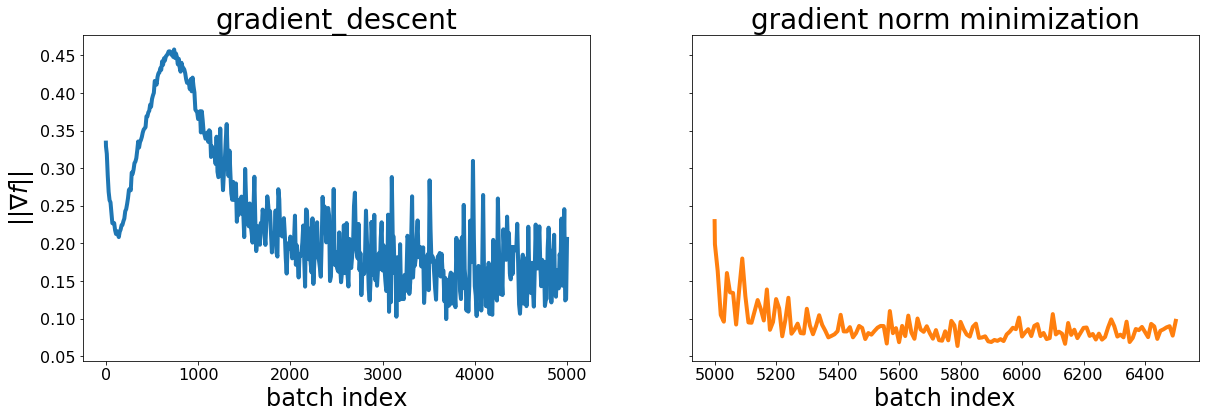

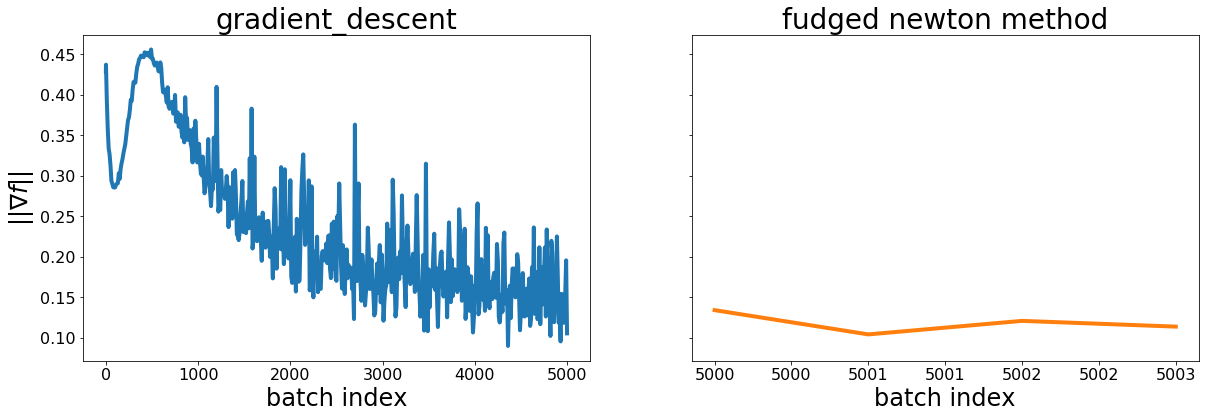

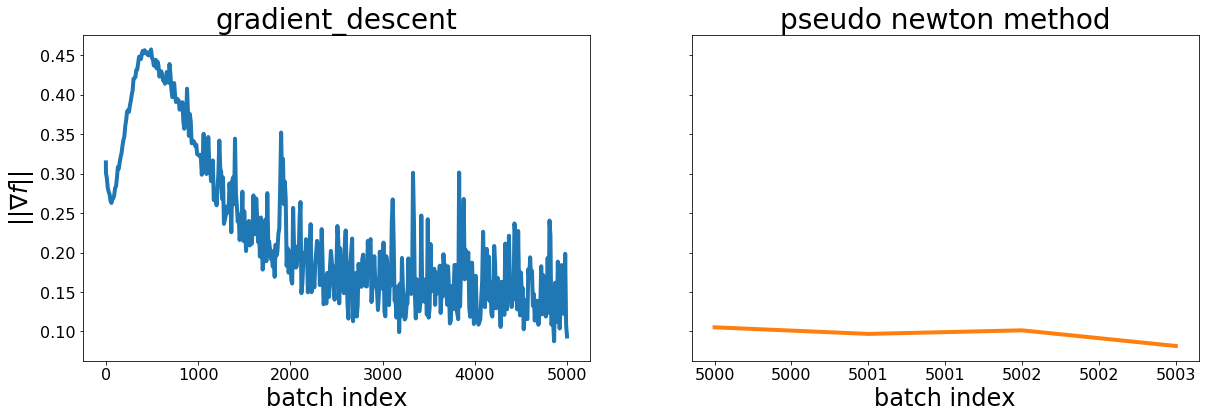

In [8]:
evaluate.plot_results(gd_results_gnm, gnm_results,
                      ["gradient_descent","gradient norm minimization"])
evaluate.plot_results(gd_results_fn, fudged_newton_results,
                      ["gradient_descent", "fudged newton method"])
evaluate.plot_results(gd_results_pn, pseudo_newton_results,
                      ["gradient_descent","pseudo newton method"])

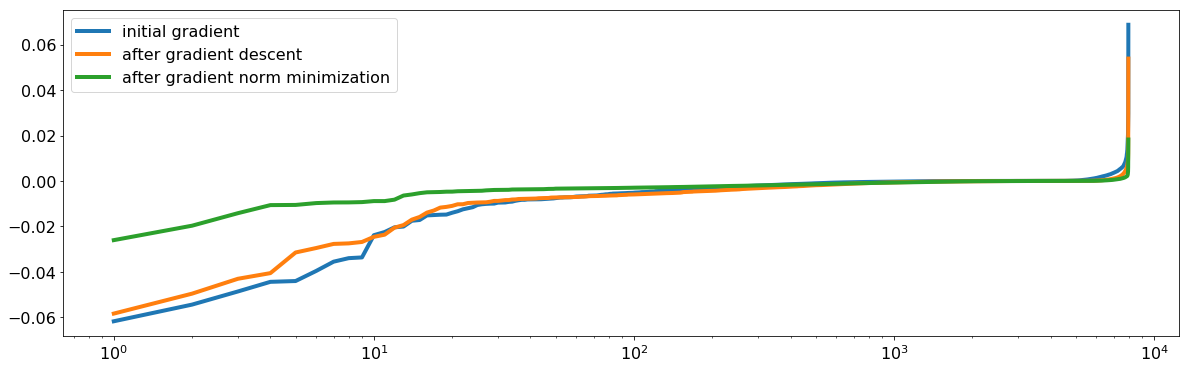

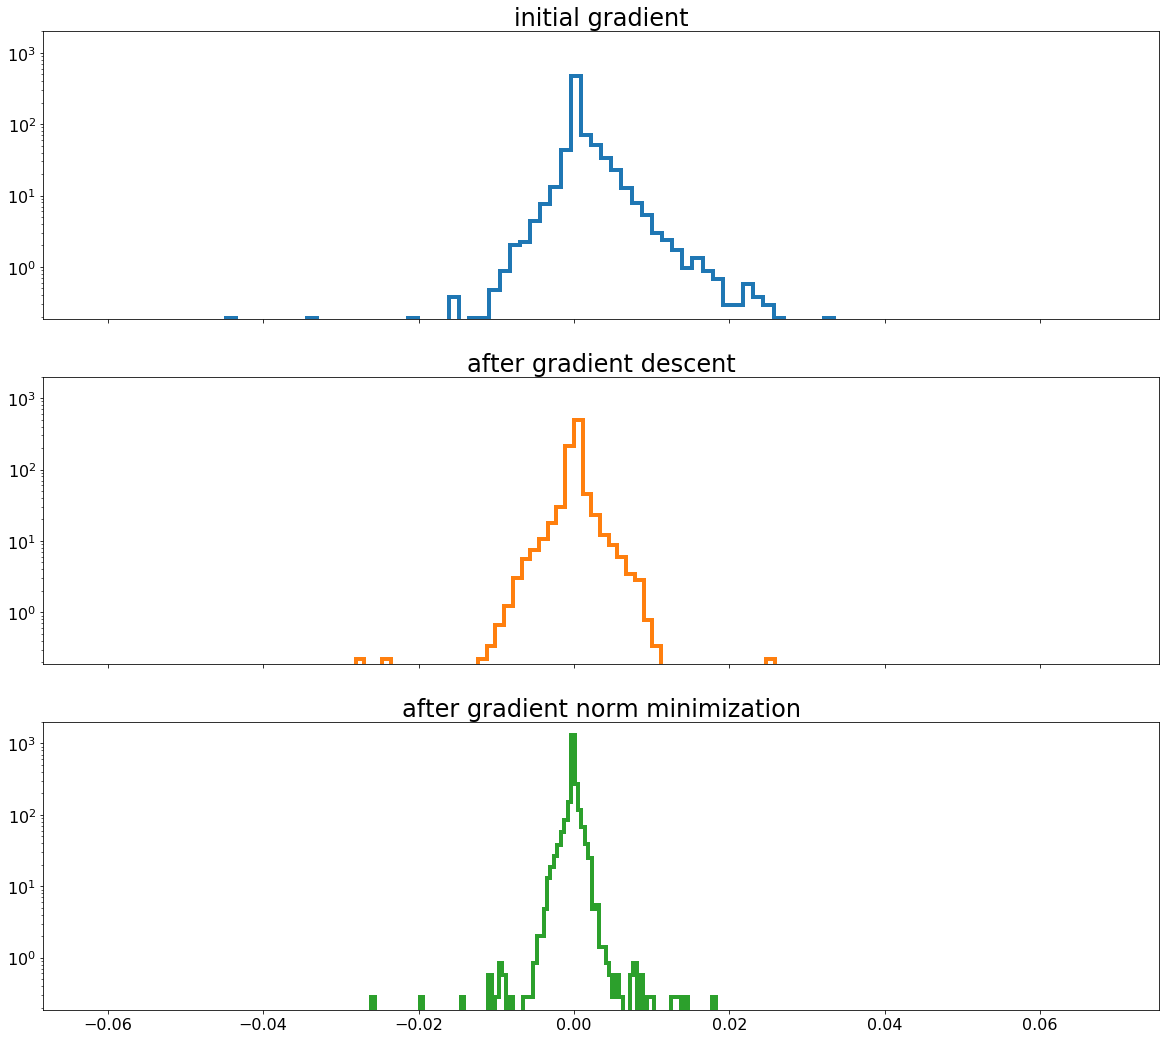

In [9]:
labels = ["initial gradient", "after gradient descent", "after gradient norm minimization"]

evaluate.compare_gradients_entrywise(gd_results_gnm, gnm_results, labels)

evaluate.compare_gradient_histograms(gd_results_gnm, gnm_results, labels)

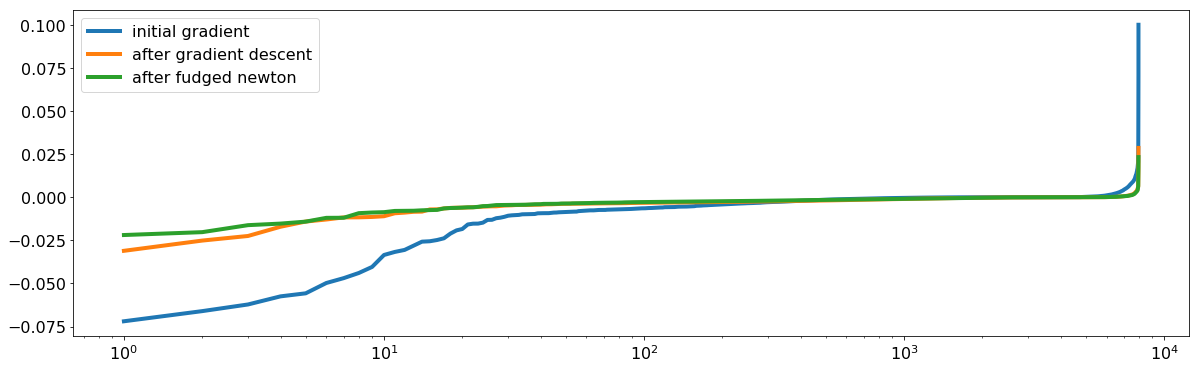

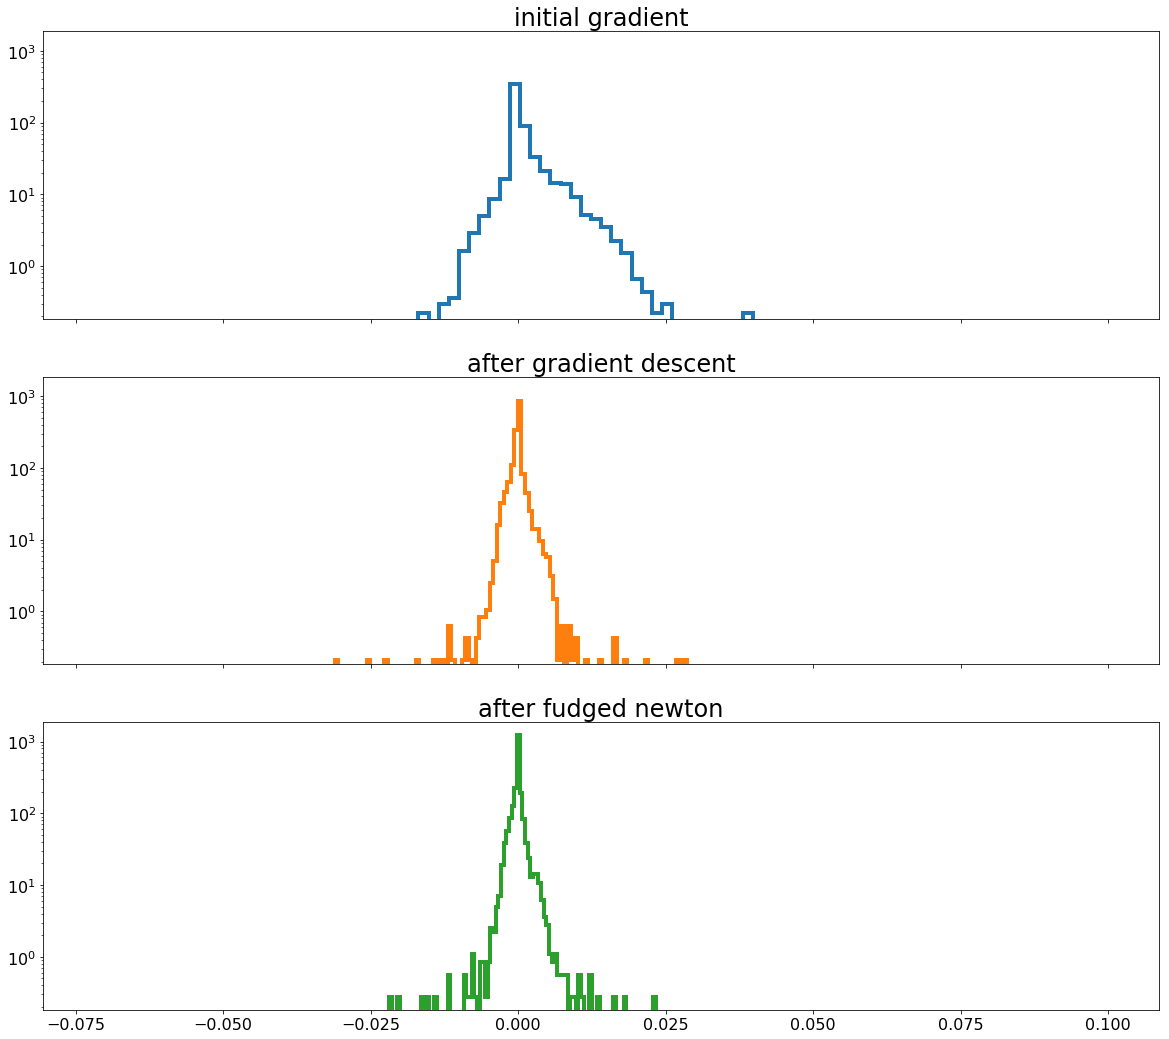

In [10]:
labels = ["initial gradient", "after gradient descent", "after fudged newton"]

evaluate.compare_gradients_entrywise(gd_results_fn, fudged_newton_results, labels)

evaluate.compare_gradient_histograms(gd_results_fn, fudged_newton_results, labels)

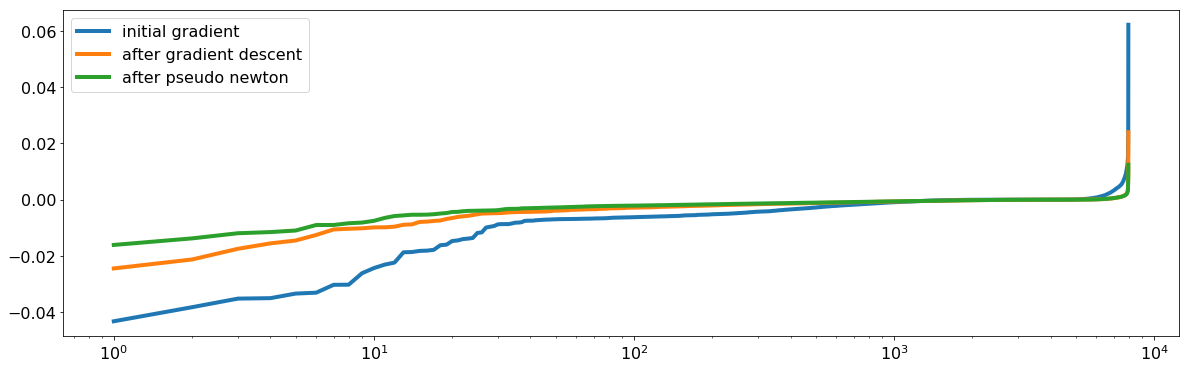

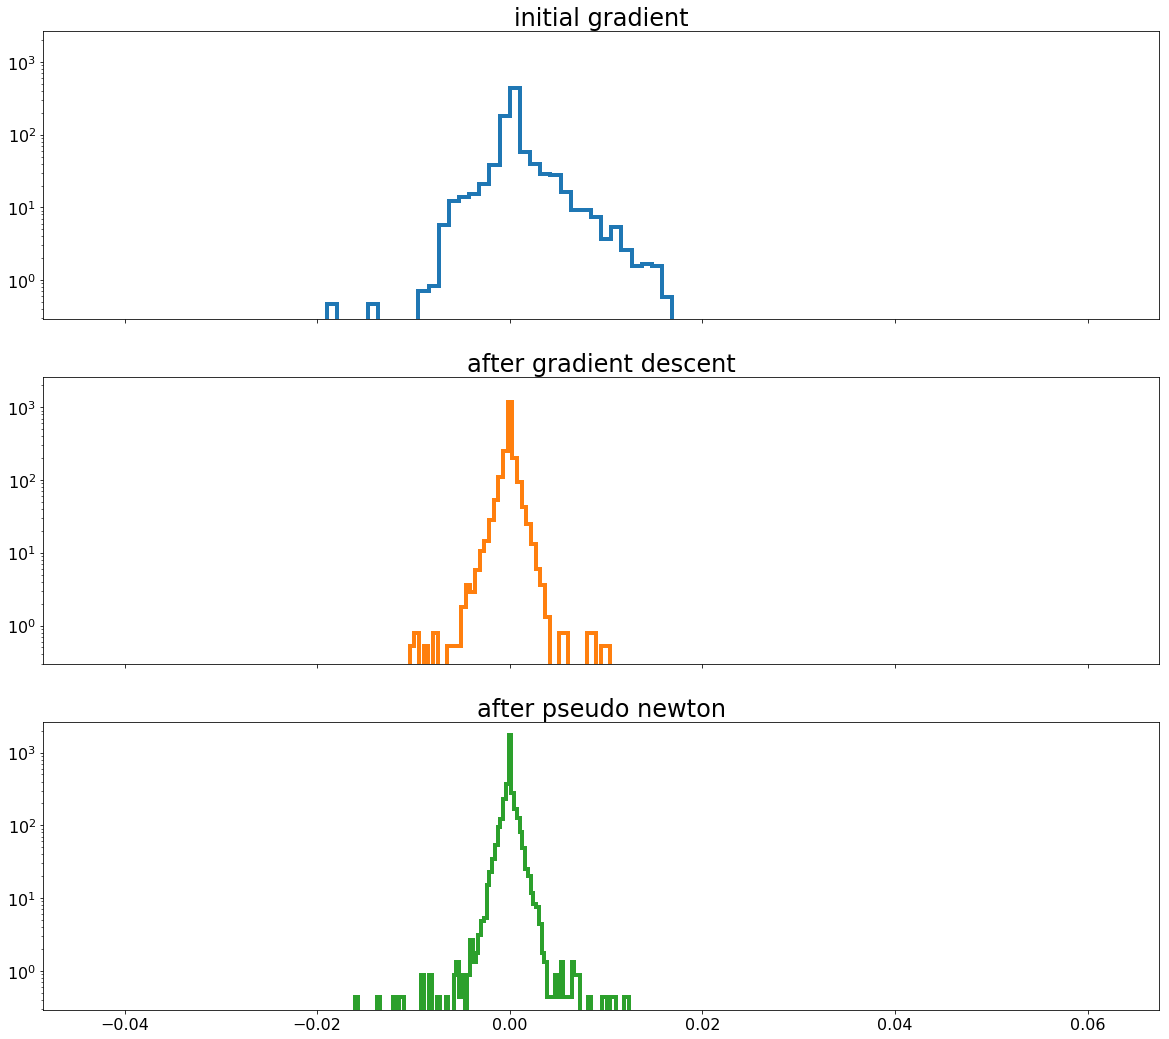

In [11]:
labels = ["initial gradient", "after gradient descent", "after pseudo newton"]

evaluate.compare_gradients_entrywise(gd_results_pn, pseudo_newton_results, labels)

evaluate.compare_gradient_histograms(gd_results_pn, pseudo_newton_results, labels)